In [1]:
import torch,torchvision,os,time
import torchvision.transforms as transforms
import numpy as np
from utils.util import get_loader,evaluate
from utils.layer import qConv2d,qLinear
from utils.train import QAVAT_train
import matplotlib.pyplot as plt
import torchvision.models as models             

from mqbench.prepare_by_platform import prepare_by_platform   # add quant nodes for specific Backend
from mqbench.prepare_by_platform import BackendType           # contain various Backend, like TensorRT, NNIE, etc.
from mqbench.utils.state import enable_calibration            # turn on calibration algorithm, determine scale, zero_point, etc.
from mqbench.utils.state import enable_quantization           # turn on actually quantization, like FP32 -> INT8
from mqbench.utils.state import disable_all           
from copy import deepcopy
from mqbench.advanced_ptq import ptq_reconstruction
torch.manual_seed(0)
np.random.seed(0)

In [2]:
from mltools.data import I1K
import torchvision as tv

modelname = 'resnet50'
adv_ptq = False
dataset = 'I1K'
mn = dataset.lower()+ '_' + modelname
ds = I1K(data_dir=os.path.join('/tools/d-matrix/ml/data', "imagenet"),
         train_batch_size=32,test_batch_size=32,cuda=True)
model = eval("tv.models." + modelname)(pretrained=True).cuda()
ds.train.num_workers = 4
ds.val.num_workers = 4

train = ds.train
test = ds.val


/homes/zdeng/.conda/envs/mltls/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def evaluate(val_loader, model,
             criterion = torch.nn.CrossEntropyLoss().cuda(),device='cuda'):
    s_time = time.time()
    # switch to evaluate mode
    model.eval()
    count,top1,top5,losses = 0,0,0,0
    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            images, target = images.to(device), target.to(device)
            # compute output
            output = model(images)
            loss = criterion(output, target)
            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses = losses * count/(count+images.size(0)) + loss * images.size(0)/(count+images.size(0))
            top1 = top1 * count/(count+images.size(0)) + acc1 * images.size(0)/(count+images.size(0))
            top5 = top5 * count/(count+images.size(0)) + acc5 * images.size(0)/(count+images.size(0))
            count += images.size(0)
    test_time = time.time() - s_time
    
    return {'top1':top1,'top5':top5,'loss':losses,'time':test_time}

    

In [4]:

evaluate(test,model)

{'top1': tensor([76.1461], device='cuda:0'),
 'top5': tensor([92.8723], device='cuda:0'),
 'loss': tensor(0.9616, device='cuda:0'),
 'time': 128.68245339393616}

In [ ]:
adv_ptq = False
dataset = 'cifar100'
modelname = 'resnet56'
mn = dataset.lower()+ '_' + modelname
model = torch.hub.load("chenyaofo/pytorch-cifar-models", mn, pretrained=True).cuda()
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_mobilenetv2_x0_5", pretrained=True).cuda()
model.eval()
torch.manual_seed(0)
np.random.seed(0)
train,test = get_loader(dataset.upper(),batch_size=128,test_batch_size=128)
train.num_workers = 2
test.num_workers = 2
train.pin_in_memory = True
test.pin_in_memory = True

In [ ]:
evaluate(test,model)

In [5]:
# calibration data used to calibrate PTQ and MPQ
calib_data = []
stacked_tensor = []
calib_fp_output = []
i = 0
with torch.no_grad():
    for img,label in train:
        i += 1
        stacked_tensor.append(img)
        calib_data.append((img,label))
        calib_fp_output.append(model(img.cuda()))
        if i == 32: # remember to modify this to get 1024 images
            break


In [6]:
MPQ_scheme = (2,4,8)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# configuration
ptq_reconstruction_config_init = {
    'pattern': 'block',                   #? 'layer' for Adaround or 'block' for BRECQ and QDROP
    'scale_lr': 4.0e-5,                   #? learning rate for learning step size of activation
    'warm_up': 0.2,                       #? 0.2 * max_count iters without regularization to floor or ceil
    'weight': 0.01,                       #? loss weight for regularization item
    'max_count': 1,                   #? optimization iteration
    'b_range': [20,2],                    #? beta decaying range
    'keep_gpu': True,                     #? calibration data restore in gpu or cpu
    'round_mode': 'learned_hard_sigmoid', #? ways to reconstruct the weight, currently only support learned_hard_sigmoid
    'prob': 0.5,                          #? dropping probability of QDROP, 1.0 for Adaround and BRECQ
}


ptq_reconstruction_config = {
    'pattern': 'block',                   #? 'layer' for Adaround or 'block' for BRECQ and QDROP
    'scale_lr': 4.0e-5,                   #? learning rate for learning step size of activation
    'warm_up': 0.2,                       #? 0.2 * max_count iters without regularization to floor or ceil
    'weight': 0.01,                       #? loss weight for regularization item
    'max_count': 20000,                   #? optimization iteration
    'b_range': [20,2],                    #? beta decaying range
    'keep_gpu': True,                     #? calibration data restore in gpu or cpu
    'round_mode': 'learned_hard_sigmoid', #? ways to reconstruct the weight, currently only support learned_hard_sigmoid
    'prob': 0.5,                          #? dropping probability of QDROP, 1.0 for Adaround and BRECQ
}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
ptq_reconstruction_config = dotdict(ptq_reconstruction_config)
ptq_reconstruction_config_init = dotdict(ptq_reconstruction_config_init)

def getModuleByName(model,moduleName):
    '''
        replace module with name modelName.moduleName with newModule
    '''
    tokens = moduleName.split('.')
    m = model
    for tok in tokens:
        m = getattr(m,tok)
    return m

for b in MPQ_scheme:
    mqb_fp_model = deepcopy(model)
    
    # MSE calibration on model parameters
    backend = BackendType.Academic
    extra_config = {
        'extra_qconfig_dict': {
            'w_observer': 'MSEObserver',                              # custom weight observer
            'a_observer': 'EMAMSEObserver',                              # custom activation observer
            'w_fakequantize': 'AdaRoundFakeQuantize' if adv_ptq else 'FixedFakeQuantize',
            'a_fakequantize': 'QDropFakeQuantize' if adv_ptq else 'FixedFakeQuantize',
            'w_qscheme': {
                'bit': b,                                             # custom bitwidth for weight,
                'symmetry': True,                                    # custom whether quant is symmetric for weight,
                'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for weight,
                'pot_scale': False,                                   # custom whether scale is power of two for weight.
            },
            'a_qscheme': {
                'bit': 8,                                             # custom bitwidth for activation,
                'symmetry': False,                                    # custom whether quant is symmetric for activation,
                'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for activation,
                'pot_scale': False,                                   # custom whether scale is power of two for activation.
            }
        }                                                         # custom tracer behavior, checkout https://github.com/pytorch/pytorch/blob/efcbbb177eacdacda80b94ad4ce34b9ed6cf687a/torch/fx/_symbolic_trace.py#L836
    }
    print(f'Prepare {b}bits model using MQBench')

    exec(f'mqb_{b}bits_model=prepare_by_platform(mqb_fp_model, backend,extra_config).cuda()')
    
    # calibration loop
    enable_calibration(eval(f'mqb_{b}bits_model'))
    for img,label in calib_data:
        eval(f'mqb_{b}bits_model')(img.cuda())
    
    if adv_ptq:
        if os.path.exists(f'QDROP_{b}bits_{mn}.pt'):
            exec(f'mqb_{b}bits_model=ptq_reconstruction(mqb_{b}bits_model, stacked_tensor, ptq_reconstruction_config_init).cuda()')
            print(f'QDROP model already saved, now loading QDROP_{b}bits_{mn}.pt')
            load_from = f'QDROP_{b}bits_{mn}.pt'
            exec(f'mqb_{b}bits_model.load_state_dict(torch.load(load_from))')
        else:
            
            exec(f'mqb_{b}bits_model=ptq_reconstruction(mqb_{b}bits_model, stacked_tensor, ptq_reconstruction_config).cuda()')
            print(f'saving QDROP tuned model: QDROP_{b}bits_{mn}.pt...')
            torch.save(eval(f'mqb_{b}bits_model').state_dict(),f'QDROP_{b}bits_{mn}.pt')

Prepare 2bits model using MQBench
[MQBENCH] INFO: Quantize model Scheme: BackendType.Academic Mode: Eval
[MQBENCH] INFO: Weight Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      MSEObserver Params: Symmetric: True / Bitwidth: 2 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Activation Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      EMAMSEObserver Params: Symmetric: False / Bitwidth: 8 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Replace module to qat module.
[MQBENCH] INFO: Set layer conv1 to 8 bit.
[MQBENCH] INFO: Set layer fc to 8 bit.
dbg node_to_quantize_output
 odict_keys([x, maxpool, layer1_0_relu, layer1_0_relu_1, layer1_0_relu_2, layer1_1_relu, layer1_1_relu_1, layer1_1_relu_2, layer1_2_relu, layer1_2_relu_1, layer1_2_relu_2, layer2_0_relu, layer2_0_relu_1, layer2_0_relu_2, layer2_1_relu, layer2_1_relu_1, layer2_1_relu_2, layer2_2_relu, layer2_2_relu_1, layer2_2_relu_2, l

[MQBENCH] INFO: Insert act quant layer2_3_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_3_relu_2_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_0_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_0_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_0_relu_2_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_1_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_1_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_1_relu_2_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_2_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_2_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_2_relu_2_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_3_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_3_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_3_relu_2_post_act_f

In [8]:
for b in MPQ_scheme: 
    disable_all(eval(f'mqb_{b}bits_model'))
    # evaluation loop
    enable_quantization(eval(f'mqb_{b}bits_model'))
    eval(f'mqb_{b}bits_model').eval()
    print('evaluate mqb quantized model')
    print(evaluate(test,eval(f'mqb_{b}bits_model')))

[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([0.1000], device='cuda:0'), 'top5': tensor([0.5060], device='cuda:0'), 'loss': tensor(6.9102, device='cuda:0'), 'time': 159.67581582069397}
[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([45.4260], device='cuda:0'), 'top5': tensor([70.3861], device='cuda:0'), 'loss': tensor(2.5618, device='cuda:0'), 'time': 160.9207420349121}
[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([75.7820], device='cuda:0'), 'top5': tensor([92.7382], device='cuda:0'), 'loss': tensor(0.9645, device='cuda:0'), 'time': 161.9973521232605}


In [9]:
mqb_fp_model = deepcopy(mqb_8bits_model)
disable_all(mqb_fp_model)
mqb_mix_model = deepcopy(mqb_fp_model)

# 1. record all modules we want to consider
types_to_quant = (torch.nn.Conv2d,torch.nn.Linear)

layer_input_map = {}

for node in mqb_8bits_model.graph.nodes:
    try:
        node_target = getModuleByName(mqb_mix_model,node.target)
        if isinstance(node_target,types_to_quant):
            node_args = node.args[0]
            print('input of ',node.target,' is ',node_args)
            layer_input_map[node.target] = str(node_args.target)
    except:
        continue

[MQBENCH] INFO: Disable observer and Disable quantize.
input of  conv1  is  x_post_act_fake_quantizer
input of  layer1.0.conv1  is  maxpool_post_act_fake_quantizer
input of  layer1.0.conv2  is  layer1_0_relu_post_act_fake_quantizer
input of  layer1.0.conv3  is  layer1_0_relu_1_post_act_fake_quantizer
input of  layer1.0.downsample.0  is  maxpool_post_act_fake_quantizer
input of  layer1.1.conv1  is  layer1_0_relu_2_post_act_fake_quantizer
input of  layer1.1.conv2  is  layer1_1_relu_post_act_fake_quantizer
input of  layer1.1.conv3  is  layer1_1_relu_1_post_act_fake_quantizer
input of  layer1.2.conv1  is  layer1_1_relu_2_post_act_fake_quantizer
input of  layer1.2.conv2  is  layer1_2_relu_post_act_fake_quantizer
input of  layer1.2.conv3  is  layer1_2_relu_1_post_act_fake_quantizer
input of  layer2.0.conv1  is  layer1_2_relu_2_post_act_fake_quantizer
input of  layer2.0.conv2  is  layer2_0_relu_post_act_fake_quantizer
input of  layer2.0.conv3  is  layer2_0_relu_1_post_act_fake_quantizer
input

In [ ]:
ref_metric = ('mean_acc',evaluate(test,mqb_fp_model)['mean_acc'])
ref_metric = ('mean_loss',evaluate(calib_data,mqb_fp_model)['mean_loss'])

In [10]:
ref_metric = ('loss',evaluate(calib_data,mqb_fp_model)['loss'])

In [11]:
def perturb(perturb_scheme):
    # perturb_scheme: {layer_name:(act_bits,weight_bits)}
    for layer_name in perturb_scheme:
        a_bits,w_bits = perturb_scheme[layer_name]
        
        if w_bits is not None:
            mix_module = getModuleByName(mqb_mix_model,layer_name)
            tar_module = getModuleByName(eval(f'mqb_{w_bits}bits_model'),layer_name)
            # replace weight quant to use a_bits quantization
            w_cmd = f'mix_module.weight_fake_quant=tar_module.weight_fake_quant'
            exec(w_cmd)
        
        if a_bits is not None:
        
            # replace act quant to use w_bits quantization
            a_cmd = f'mqb_mix_model.{layer_input_map[layer_name]}=mqb_{a_bits}bits_model.{layer_input_map[layer_name]}'
            exec(a_cmd)
        
        #print(layer_name)
        #print(a_cmd)
        #print(w_cmd)


In [12]:
# perturb functionality test
perturb_scheme = {}
for layer_name in layer_input_map:
    perturb_scheme[layer_name] = (8,8)
perturb(perturb_scheme)

In [13]:
evaluate(test,mqb_mix_model)

{'top1': tensor([75.7820], device='cuda:0'),
 'top5': tensor([92.7382], device='cuda:0'),
 'loss': tensor(0.9645, device='cuda:0'),
 'time': 161.94112491607666}

In [14]:
mqb_mix_model = deepcopy(mqb_8bits_model)
disable_all(mqb_mix_model)
evaluate(test,mqb_mix_model)

[MQBENCH] INFO: Disable observer and Disable quantize.


{'top1': tensor([76.1461], device='cuda:0'),
 'top5': tensor([92.8723], device='cuda:0'),
 'loss': tensor(0.9616, device='cuda:0'),
 'time': 144.14754939079285}

## CLADO

In [15]:
import torch.nn.functional as F
kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
def kldiv(quant_logit,fp_logit):
    inp = F.log_softmax(quant_logit,dim=-1)
    tar = F.softmax(fp_logit,dim=-1)
    return kl_loss(inp,tar)

def perturb_loss(perturb_scheme,ref_metric=ref_metric,
                 eval_data=calib_data,printInfo=False,KL=False):
    
    global mqb_mix_model
    mqb_mix_model.eval()
    
    with torch.no_grad():
        # perturb layers
        perturb(perturb_scheme)
            
        # do evaluation
        if not KL:
            res = evaluate(eval_data,mqb_mix_model)
            perturbed_loss = res[ref_metric[0]] - ref_metric[1]
        else:
            perturbed_loss = []
            
            for (data,fp_out) in zip(calib_data,calib_fp_output):
                img,label = data
                quant_out = mqb_mix_model(img.cuda())
                perturbed_loss.append(kldiv(quant_out,fp_out))
            #print(perturbed_loss)
            perturbed_loss = torch.tensor(perturbed_loss).mean()    
        
        if printInfo:
            print(f'use kl {KL} perturbed loss {perturbed_loss}')
        
        # recover layers
        mqb_mix_model = deepcopy(mqb_fp_model)
            
    return perturbed_loss

In [ ]:
# perturb loss functionality check
# del layer_input_map['conv1']
# del layer_input_map['fc']

# for layer in layer_input_map:
#     for a_bits in MPQ_scheme:
#         for w_bits in MPQ_scheme:
#             print(f'{layer} (a:{a_bits} bits,w:{w_bits} bits))')
#             p = perturb_loss({layer:(a_bits,w_bits)},eval_data=test,printInfo=True,KL=False)
#             #print(f'{layer} (a:{a_bits} bits,w:{w_bits} bits), accuracy degradation: {p*100:.2f}%')

## Build Cached Grad if not done before

In [ ]:
del layer_input_map['conv1']
del layer_input_map['fc']

import time
s_time = time.time()
cached = {}
aw_scheme = []
for a_bits in MPQ_scheme:
    for w_bits in MPQ_scheme:
        aw_scheme.append((a_bits,w_bits))

aw_scheme = [(8,2),(8,4),(8,8)]

In [ ]:
aw_scheme

In [ ]:
KL=True
for n in layer_input_map:
    for m in layer_input_map:
        for naw in aw_scheme:
            for maw in aw_scheme:
                if (n,m,naw,maw) not in cached:
                    if n == m:
                        if naw == maw:
                            
                            p = perturb_loss({n:naw},ref_metric,calib_data,KL=KL)
                            print(f'perturb layer {n} to A{naw[0]}W{naw[1]} p={p}')
                        else:
                            p = 0

                    else:
                        
                        p = perturb_loss({n:naw,m:maw},ref_metric,calib_data,KL=KL)
                        print(f'perturb layer {n} to A{naw[0]}W{naw[1]} and layer {m} to A{maw[0]}W{maw[1]} p={p}')
                    
                    cached[(n,m,naw,maw)] = cached[(m,n,maw,naw)] = p
                    
print(f'{time.time()-s_time:.2f} seconds elapsed')

In [ ]:
cached

In [ ]:
layer_index = {}
cnt = 0
for layer in layer_input_map:
    for s in aw_scheme:
        layer_index[layer+f'{s}bits'] = cnt
        cnt += 1
L = cnt

In [ ]:
layer_index

In [ ]:
import numpy as np
hm = np.zeros(shape=(L,L))
for n in layer_input_map:
    for m in layer_input_map:
        for naw in aw_scheme:
            for maw in aw_scheme:
                hm[layer_index[n+f'{naw}bits'],layer_index[m+f'{maw}bits']] = cached[(n,m,naw,maw)]

In [ ]:
cached_grad = np.zeros_like(hm)

In [ ]:
import pickle
with open('generala248w248_i1kresnet50_calib','wb') as f:
    pickle.dump({'Ltilde':hm,'layer_index':layer_index},f)

In [ ]:
perturb_loss(['conv1',],ref_metric,eval_data=calib_data)

## Load Cached Grad

In [17]:
import pickle
# with open('generala248w248_c100resnet56_calib','rb') as f:
# with open('CachedGrad_QDROP(2, 4, 8)cifar100_resnet56.pkl','rb') as f:
with open('CachedGrad_((8, 2), (8, 4), (8, 8))i1k_resnet50.pkl','rb') as f:
    hm = pickle.load(f)

In [18]:
hm.keys()

dict_keys(['Ltilde', 'layer_index'])

In [19]:
hm['layer_index']

{'layer1.0.conv1(8, 2)bits': 0,
 'layer1.0.conv1(8, 4)bits': 1,
 'layer1.0.conv1(8, 8)bits': 2,
 'layer1.0.conv2(8, 2)bits': 3,
 'layer1.0.conv2(8, 4)bits': 4,
 'layer1.0.conv2(8, 8)bits': 5,
 'layer1.0.conv3(8, 2)bits': 6,
 'layer1.0.conv3(8, 4)bits': 7,
 'layer1.0.conv3(8, 8)bits': 8,
 'layer1.0.downsample.0(8, 2)bits': 9,
 'layer1.0.downsample.0(8, 4)bits': 10,
 'layer1.0.downsample.0(8, 8)bits': 11,
 'layer1.1.conv1(8, 2)bits': 12,
 'layer1.1.conv1(8, 4)bits': 13,
 'layer1.1.conv1(8, 8)bits': 14,
 'layer1.1.conv2(8, 2)bits': 15,
 'layer1.1.conv2(8, 4)bits': 16,
 'layer1.1.conv2(8, 8)bits': 17,
 'layer1.1.conv3(8, 2)bits': 18,
 'layer1.1.conv3(8, 4)bits': 19,
 'layer1.1.conv3(8, 8)bits': 20,
 'layer1.2.conv1(8, 2)bits': 21,
 'layer1.2.conv1(8, 4)bits': 22,
 'layer1.2.conv1(8, 8)bits': 23,
 'layer1.2.conv2(8, 2)bits': 24,
 'layer1.2.conv2(8, 4)bits': 25,
 'layer1.2.conv2(8, 8)bits': 26,
 'layer1.2.conv3(8, 2)bits': 27,
 'layer1.2.conv3(8, 4)bits': 28,
 'layer1.2.conv3(8, 8)bits': 29,

In [20]:
hm['Ltilde'].shape

(156, 156)

In [21]:
index2layerscheme = [None for i in range(hm['Ltilde'].shape[0])]

for name in hm['layer_index']:
    index = hm['layer_index'][name]
    layer_name = name[:-10]
    scheme = name[-10:]
    a = hm['Ltilde']
    print(f'index {index} layer {layer_name} scheme {scheme} Ltilde {a[index,index].item():.6f}')
    
    index2layerscheme[index] = (layer_name,scheme)
    

index 0 layer layer1.0.conv1 scheme (8, 2)bits Ltilde 0.130802
index 1 layer layer1.0.conv1 scheme (8, 4)bits Ltilde 0.054223
index 2 layer layer1.0.conv1 scheme (8, 8)bits Ltilde 0.004730
index 3 layer layer1.0.conv2 scheme (8, 2)bits Ltilde 0.356665
index 4 layer layer1.0.conv2 scheme (8, 4)bits Ltilde 0.097498
index 5 layer layer1.0.conv2 scheme (8, 8)bits Ltilde -0.000108
index 6 layer layer1.0.conv3 scheme (8, 2)bits Ltilde 0.693197
index 7 layer layer1.0.conv3 scheme (8, 4)bits Ltilde 0.016067
index 8 layer layer1.0.conv3 scheme (8, 8)bits Ltilde 0.000699
index 9 layer layer1.0.downsample.0 scheme (8, 2)bits Ltilde 1.486260
index 10 layer layer1.0.downsample.0 scheme (8, 4)bits Ltilde 0.194110
index 11 layer layer1.0.downsample.0 scheme (8, 8)bits Ltilde 0.005257
index 12 layer layer1.1.conv1 scheme (8, 2)bits Ltilde 0.134360
index 13 layer layer1.1.conv1 scheme (8, 4)bits Ltilde -0.003364
index 14 layer layer1.1.conv1 scheme (8, 8)bits Ltilde 0.000073
index 15 layer layer1.1.con

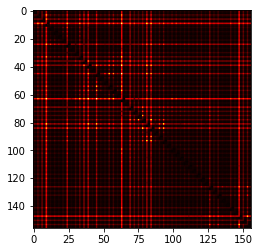

In [22]:
plt.imshow(hm['Ltilde'],cmap='hot')

In [23]:
L = hm['Ltilde'].shape[0]
cached_grad = np.zeros_like(hm['Ltilde'])
for i in range(L):
    for j in range(L):
        layer_i,scheme_i = index2layerscheme[i]
        layer_j,scheme_j = index2layerscheme[j]
        if layer_i == layer_j:
            if scheme_i == scheme_j:
                cached_grad[i,j] = cached_grad[j,i] = 2 * hm['Ltilde'][i,j]
            else:
                #cached_grad[i,j] = cached_grad[j,i] = 4 * hm['Ltilde'][i,j] - hm['Ltilde'][i,i] - hm['Ltilde'][j,j]
                cached_grad[i,j] = cached_grad[j,i] = 0
        else:
            cached_grad[i,j] = cached_grad[j,i] = hm['Ltilde'][i,j] - hm['Ltilde'][i,i] - hm['Ltilde'][j,j]
        '''
        print(index2layerscheme[i])
        print(index2layerscheme[j])
        '''
        '''
        if i == j:
            cached_grad[i,j] = 0.5 * hm['Ltilde'][i,j]
        else:
            cached_grad[i,j] = 0.25 * (hm['Ltilde'][i,j]-hm['Ltilde'][i,i]-hm['Ltilde'][j,j])
        '''

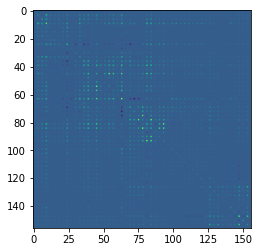

In [24]:
# cached_grad[cached_grad<0]=0
plt.imshow(cached_grad)

In [25]:
cached_grad.shape

(156, 156)

In [26]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Hook to record input and output shapes of layers

In [27]:
class layer_hook(object):

    def __init__(self):
        super(layer_hook, self).__init__()
        self.in_shape = None
        self.out_shape = None

    def hook(self, module, inp, outp):
        self.in_shape = inp[0].size()
        self.out_shape = outp.size()
    

hooks = {}

for layer in hm['layer_index']:
    m = getModuleByName(model,layer[:-10])
    hook = layer_hook()
    hooks[layer[:-10]] = (hook,m.register_forward_hook(hook.hook))

In [28]:
# for layer in hooks:
#     hooks[layer][1].remove()

In [29]:
with torch.no_grad():
    for img,label in train:
        model(img.cuda())
        break

In [30]:
def get_layer_bitops(layer_name,a_bits,w_bits):
    
    m = getModuleByName(model,layer_name)
    
    if isinstance(m,torch.nn.Conv2d):
        _,cin,_,_ = hooks[layer_name][0].in_shape
        _,cout,hout,wout = hooks[layer_name][0].out_shape
        
#         print('in',hooks[layer_name][0].in_shape)
#         print('out',hooks[layer_name][0].out_shape)
        
        n_muls = cin * m.weight.size()[2] * m.weight.size()[3] * cout * hout * wout
        n_accs = (cin * m.weight.size()[2] * m.weight.size()[3] - 1) * cout * hout * wout
        
        bitops_per_mul = 2 * a_bits * w_bits
        bitops_per_acc = (a_bits + w_bits) + np.ceil(np.log2(cin * m.weight.size()[2] * m.weight.size()[3]))
        
#         print(f'n_muls {n_muls} ops_per_mul {bitops_per_mul} totl {n_muls*bitops_per_mul}')
#         print(f'n_accs {n_accs} ops_per_acc {bitops_per_acc} totl {n_accs*bitops_per_acc}')
#         print()
        
        return n_muls * bitops_per_mul + n_accs * bitops_per_acc
        
        
    

In [31]:
index2layerscheme

[('layer1.0.conv1', '(8, 2)bits'),
 ('layer1.0.conv1', '(8, 4)bits'),
 ('layer1.0.conv1', '(8, 8)bits'),
 ('layer1.0.conv2', '(8, 2)bits'),
 ('layer1.0.conv2', '(8, 4)bits'),
 ('layer1.0.conv2', '(8, 8)bits'),
 ('layer1.0.conv3', '(8, 2)bits'),
 ('layer1.0.conv3', '(8, 4)bits'),
 ('layer1.0.conv3', '(8, 8)bits'),
 ('layer1.0.downsample.0', '(8, 2)bits'),
 ('layer1.0.downsample.0', '(8, 4)bits'),
 ('layer1.0.downsample.0', '(8, 8)bits'),
 ('layer1.1.conv1', '(8, 2)bits'),
 ('layer1.1.conv1', '(8, 4)bits'),
 ('layer1.1.conv1', '(8, 8)bits'),
 ('layer1.1.conv2', '(8, 2)bits'),
 ('layer1.1.conv2', '(8, 4)bits'),
 ('layer1.1.conv2', '(8, 8)bits'),
 ('layer1.1.conv3', '(8, 2)bits'),
 ('layer1.1.conv3', '(8, 4)bits'),
 ('layer1.1.conv3', '(8, 8)bits'),
 ('layer1.2.conv1', '(8, 2)bits'),
 ('layer1.2.conv1', '(8, 4)bits'),
 ('layer1.2.conv1', '(8, 8)bits'),
 ('layer1.2.conv2', '(8, 2)bits'),
 ('layer1.2.conv2', '(8, 4)bits'),
 ('layer1.2.conv2', '(8, 8)bits'),
 ('layer1.2.conv3', '(8, 2)bits'),

In [32]:
layer_size = np.array([0 for i in range(L)])
for l in hm['layer_index']:
    index = hm['layer_index'][l]
    layer_name, scheme = index2layerscheme[index]
    scheme = eval(scheme[:-4])
    layer_size[index] = torch.numel(getModuleByName(model,layer_name).weight) * int(scheme[1])

layer_bitops = []

### Calculate sizes and numbers of bitoperations for layers under different quantization options

In [33]:
layer_size = np.array([0 for i in range(L)])
layer_bitops = np.array([0 for i in range(L)])
for l in hm['layer_index']:
    index = hm['layer_index'][l]
    layer_name, scheme = index2layerscheme[index]
    a_bits,w_bits = eval(scheme[:-4])
    #print(layer_name,a_bits,w_bits)
    layer_size[index] = torch.numel(getModuleByName(model,layer_name).weight) * int(w_bits)
    layer_bitops[index] = get_layer_bitops(layer_name,a_bits,w_bits)

In [34]:
# layer_size # list[layer_index] = size of layer with layer_index

In [35]:
# layer_bitops # list[layer_index] = bitops of layer with layer_index

## Modify the quantization options for layers
modify the aw_scheme to list of (a_bits,w_bits) so that CLADO will only consider to choose from these options.
the corresponding cached_grad, layer_size, layer_bitops will also exclude quantization options that are not considered

In [36]:
cached_grad_full = deepcopy(cached_grad)
index2layerscheme_full = deepcopy(index2layerscheme)
layer_size_full = deepcopy(layer_size)
layer_bitops_full = deepcopy(layer_bitops)

In [38]:
MPQ_scheme = (2,4,8)
aw_scheme = []
for a_bits in MPQ_scheme:
    for w_bits in MPQ_scheme:
        aw_scheme.append((a_bits,w_bits))

aw_scheme = [(4,8),(8,8),(8,4),(4,4)]
aw_scheme = [(8,2),(8,4),(8,8)]

del_index = []
for index in range(len(index2layerscheme_full)):
    if eval(index2layerscheme_full[index][1][:-4]) not in aw_scheme:
        del_index.append(index)
        print(f'delete {index}: {index2layerscheme_full[index][1]}')

cached_grad = np.delete(cached_grad_full,[del_index],axis=0)
cached_grad = np.delete(cached_grad,[del_index],axis=1)
index2layerscheme = np.delete(index2layerscheme_full,[del_index],axis=0)
layer_size = np.delete(layer_size_full,[del_index],axis=0)
layer_bitops = np.delete(layer_bitops_full,[del_index],axis=0)

In [39]:
aw_scheme

[(8, 2), (8, 4), (8, 8)]

In [40]:
cached_grad.shape

(156, 156)

In [41]:
# initialize random variable v
# use recitfied sigmoid h(v) to represent alpha
# freg is 1-(1-2h(v))**beta, annealing beta to 

if not isinstance(cached_grad,torch.Tensor):
    cached_grad = torch.Tensor(cached_grad)

layer_size_tensor = torch.Tensor(layer_size)
layer_bitops_tensor = torch.Tensor(layer_bitops)

def lossfunc(v,beta,lambda1,lambda2,printInfo=False,naive=False,b=None):
    alpha = torch.nn.Softmax(dim=1)(v.reshape(-1,len(aw_scheme))).reshape(-1,)
    
    if not naive:
        outer_alpha = torch.outer(alpha,alpha)
        netloss = torch.sum(outer_alpha * cached_grad)
    else:
        netloss = torch.sum(torch.diagonal(cached_grad) * alpha)
        
    model_size = torch.sum(layer_size_tensor * alpha)/8/1024/1024 # model size in MB
    model_bitops = torch.sum(layer_bitops_tensor * alpha)/10**9
            
    regloss = torch.sum(1-(torch.abs(1-2*alpha))**beta)
    regloss *= lambda1

    if b is None:
        closs = lambda2 * model_bitops
    else:
        closs = lambda2 * torch.clamp(model_bitops-b,0)
    
    totloss = netloss + regloss + closs
    
    if printInfo:
        print(f'netloss {netloss.item():.4f} regloss {regloss.item():.4f}(beta={beta:.4f}) closs{closs.item():.4f}(bitops: {model_bitops.item():.2f}G constraint:{b})')
        print(f'model size: {model_size.item():.4f}MB')
        print('alpha:\n',alpha)
        
    return totloss    
    

In [42]:
L = cached_grad.size()[0]
def optimize(n_iteration,lr,beta,lambda1,lambda2,b=None,naive=False,hardInit=False):
    
    
    #v = torch.nn.Parameter(torch.randn(L))
    v = torch.nn.Parameter(torch.zeros(L))
    if hardInit:
        v = torch.nn.Parameter(torch.zeros(L))
        with torch.no_grad():
            for i in range(L):
                if i % len(aw_scheme) == len(aw_scheme)-1:
                    v[i].data += 1.
                    
    optim = torch.optim.Adam([v,],lr=lr)
    bs = np.linspace(beta[0],beta[1],n_iteration)
    
    for i in range(n_iteration):
        if i==0 or (i+1) % 1000 == 0:
            printInfo = True
            print(f'Iter {i+1}')
        else:
            printInfo = False
            
        optim.zero_grad()
        loss = lossfunc(v,bs[i],lambda1,lambda2,printInfo=printInfo,b=b,naive=naive)
        loss.backward()
        optim.step()
    
    return v

def evaluate_decision(v,printInfo=False,test=test):
    global mqb_mix_model
    v = v.detach()
    # alpha = torch.nn.Softmax(dim=1)(v.reshape(-1,len(MPQ_scheme)))
    offset = torch.ones(int(L/len(aw_scheme)),dtype=int) * len(aw_scheme)
    offset = offset.cumsum(dim=-1) - len(aw_scheme)
    select = v.reshape(-1,len(aw_scheme)).argmax(dim=1) + offset
    
    modelsize = (layer_size[select]).sum()/8/1024/1024
    bitops = (layer_bitops[select]).sum()/10**9
    
    decisions = {}
    for scheme_id in select.numpy():
        layer,scheme = index2layerscheme[scheme_id]
        decisions[layer] = eval(scheme[:-4])
    
    print("evaluate_decision\n",decisions)
    

    with torch.no_grad():
        
        # perturb layers
        perturb(decisions)
            
        # do evaluation
        res = evaluate(test,mqb_mix_model)
        
        # recover layers
        mqb_mix_model = deepcopy(mqb_fp_model)
    return res,modelsize,bitops

In [43]:
index2layerscheme

array([['layer1.0.conv1', '(8, 2)bits'],
       ['layer1.0.conv1', '(8, 4)bits'],
       ['layer1.0.conv1', '(8, 8)bits'],
       ['layer1.0.conv2', '(8, 2)bits'],
       ['layer1.0.conv2', '(8, 4)bits'],
       ['layer1.0.conv2', '(8, 8)bits'],
       ['layer1.0.conv3', '(8, 2)bits'],
       ['layer1.0.conv3', '(8, 4)bits'],
       ['layer1.0.conv3', '(8, 8)bits'],
       ['layer1.0.downsample.0', '(8, 2)bits'],
       ['layer1.0.downsample.0', '(8, 4)bits'],
       ['layer1.0.downsample.0', '(8, 8)bits'],
       ['layer1.1.conv1', '(8, 2)bits'],
       ['layer1.1.conv1', '(8, 4)bits'],
       ['layer1.1.conv1', '(8, 8)bits'],
       ['layer1.1.conv2', '(8, 2)bits'],
       ['layer1.1.conv2', '(8, 4)bits'],
       ['layer1.1.conv2', '(8, 8)bits'],
       ['layer1.1.conv3', '(8, 2)bits'],
       ['layer1.1.conv3', '(8, 4)bits'],
       ['layer1.1.conv3', '(8, 8)bits'],
       ['layer1.2.conv1', '(8, 2)bits'],
       ['layer1.2.conv1', '(8, 4)bits'],
       ['layer1.2.conv1', '(8, 8)bit

## Sanity Check: no constraint optimization
Without constraint, optimization should return (ideally) an 8-bit model, or performance close to 8-bit model

In [60]:
# true: 1e-2 --> 1e-4
# False 1e-1 --> 1e-3
v = optimize(n_iteration=5000,lr=2e-3,beta=[20,2],lambda1=0,lambda2=1e-2,naive=False
             ,hardInit=True)

Iter 1
netloss 29.3711 regloss 0.0000(beta=20.0000) closs4.6777(bitops: 467.77G constraint:None)
model size: 16.4358MB
alpha:
 tensor([0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761,
        0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761,
        0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761,
        0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761,
        0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761,
        0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761,
        0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761,
        0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761,
        0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761,
        0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761,
        0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0.5761, 0.2119, 0.2119, 0

In [61]:
evaluate_decision(v)

evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.0.conv3': (8, 8), 'layer1.0.downsample.0': (8, 8), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.1.conv3': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer1.2.conv3': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.conv3': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 8), 'layer2.1.conv3': (8, 8), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer2.2.conv3': (8, 8), 'layer2.3.conv1': (8, 4), 'layer2.3.conv2': (8, 4), 'layer2.3.conv3': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.conv3': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.1.conv3': (8, 8), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4), 'layer3.2.conv3': (8, 4), 'layer3.3.conv1': (8, 4), 'layer3.3.conv2': (8, 4), 'layer3.3.conv3': (8, 8), 'layer3.4.conv1': (8, 4

({'top1': tensor([70.5622], device='cuda:0'),
  'top5': tensor([89.6081], device='cuda:0'),
  'loss': tensor(1.2219, device='cuda:0'),
  'time': 159.1778359413147},
 14.62890625,
 434.336577024)

In [ ]:
evaluate_decision(v,test=calib_data)

## Random MPQ (old code to generate random MPQ schemes)

In [ ]:
# random_size = []
# random_acc = []
# for i in range(500):
#     v = torch.randn(L)
#     res,size = evaluate_decision(v)
#     random_size.append(size)
#     random_acc.append(res['mean_acc'])

# random_size,random_acc

# with open('resnet56_random_baseline.pkl','wb') as f:
#     pickle.dump({'size':random_size,'acc':random_acc},f)
    

# plt.hist(random_size)

## Pareto-Frontier of CLADO vs Inter-Layer Dependency Unaware Optimization (Naive)

In [ ]:
n_iters = (5000,)
#lambda1s = np.logspace(-5,-3,3)
lambda1s = (0,1e-1,1)
lambda2s = np.logspace(-3,0,100) # for 8 x (8,4)
sample_size = 1
results = {}
for n_iter in n_iters:
    for lambda1 in lambda1s:
        for lambda2 in lambda2s:
            feint_loss,feint_size,feint_bitops = [],[],[]
            trial_name = f'{aw_scheme}bits_CLADO_lambda1{lambda1}_lambda2{lambda2}_{n_iter}iters'
            print(trial_name)
            for repeat in range(sample_size):
                v = optimize(n_iteration=n_iter,lr=2e-3,beta=[20,2],lambda1=lambda1,lambda2=lambda2,naive=False)
                perf,size,bitops = evaluate_decision(v)
                feint_loss.append(perf)
                feint_size.append(size)
                feint_bitops.append(bitops)
            results[trial_name] = {'size':feint_size,'perf':feint_loss,'bitops':feint_bitops}

In [ ]:
results

In [ ]:
n_iters = (5000,)
lambda1s = np.logspace(-5,-3,3)
lambda1s = (0,1e-1,1)
lambda2s = np.logspace(-3,0,100) 
sample_size = 1

for n_iter in n_iters:
    for lambda1 in lambda1s:
        for lambda2 in lambda2s:
            naive_loss,naive_size,naive_bitops = [],[],[]
            print('lambda2:',lambda2)
            trial_name = f'{aw_scheme}bits_NAIVE_lambda1{lambda1}_lambda2{lambda2}_{n_iter}iters'
            for repeat in range(sample_size):
                v = optimize(n_iteration=n_iter,lr=2e-3,beta=[20,2],lambda1=lambda1,lambda2=lambda2,naive=True)
                perf,size,bitops = evaluate_decision(v)
                naive_loss.append(perf)
                naive_size.append(size)
                naive_bitops.append(bitops)
            results[trial_name] = {'size':naive_size,'perf':naive_loss,'bitops':naive_bitops}

In [ ]:
with open('generala48w48c100resnet56results.pkl','wb') as f:
    pickle.dump(results,f)

In [ ]:
# with open('saved/general48c10resnet56results.pkl','rb') as f:
#     c48 = pickle.load(f)
# with open('saved/general248c10resnet56results.pkl','rb') as f:
#     c248 = pickle.load(f)
with open('generala48w48c100resnet56results.pkl','rb') as f:
    c248 = pickle.load(f)

In [ ]:
def getPF(xs,ys):
    xs = np.array(xs)
    ys = np.array(ys)
    
    order = np.argsort(xs)
    
    xs = xs[order]
    ys = ys[order]
    
    cur_max = -1
    for i in range(ys.shape[0]):
        if ys[i] > cur_max:
            cur_max = ys[i]
        ys[i] = cur_max
    
    return xs,ys
plt.rcParams['figure.figsize'] = (12,8)

In [ ]:
# clado_size,clado_acc = [], []
# naive_size,naive_acc = [], []
# for trial in c48:
#     size = c48[trial]['size']
#     perf = c48[trial]['perf']
#     perf = [x['mean_acc'] for x in perf]
#     if 'NAIVE' in trial:
#         naive_size,naive_acc = naive_size+size,naive_acc+perf
#     if 'CLADO' in trial:
#         clado_size,clado_acc = clado_size+size,clado_acc+perf 
#     #size = np.array(size)
#     #perf = np.array(perf)
#     #size,perf = getPF(size,perf)
#     #plt.plot(size,perf,label=trial)
# c48_naive_pf = getPF(np.array(naive_size),np.array(naive_acc))
# c48_clado_pf = getPF(np.array(clado_size),np.array(clado_acc))
# plt.plot(c48_naive_pf[0],c48_naive_pf[1],label='(4,8)bits naive MPQ')
# plt.plot(c48_clado_pf[0],c48_clado_pf[1],label='(4,8)bits clado MPQ')

clado_size,clado_acc = [], []
naive_size,naive_acc = [], []
for trial in c248:
    size = c248[trial]['size']
    perf = c248[trial]['perf']
    perf = [x['mean_acc'] for x in perf]
    if 'NAIVE' in trial:
        naive_size,naive_acc = naive_size+size,naive_acc+perf
    if 'CLADO' in trial:
        clado_size,clado_acc = clado_size+size,clado_acc+perf 
    #size = np.array(size)
    #perf = np.array(perf)
    #size,perf = getPF(size,perf)
    #plt.plot(size,perf,label=trial)
c248_naive_pf = getPF(np.array(naive_size),np.array(naive_acc))
c248_clado_pf = getPF(np.array(clado_size),np.array(clado_acc))
plt.plot(c248_naive_pf[0],c248_naive_pf[1],label='(2,4,8)bits naive MPQ')
plt.plot(c248_clado_pf[0],c248_clado_pf[1],label='(2,4,8)bits clado MPQ')
plt.legend()

plt.xlim([0.4,0.7])
plt.ylim([0.88,0.95])
plt.xlabel('Hardware Cost (Model Size in MB)',fontsize=20)
plt.ylabel('Performance (Accuracy)',fontsize=20)
plt.legend()
# plt.savefig('c10resnet56_w248.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
clado_bitops,clado_acc = [], []
naive_bitops,naive_acc = [], []
for trial in c248:
    bitops = c248[trial]['bitops']
    perf = c248[trial]['perf']
    perf = [x['mean_acc'] for x in perf]
    if 'NAIVE' in trial:
        naive_bitops,naive_acc = naive_bitops+bitops,naive_acc+perf
    if 'CLADO' in trial:
        clado_bitops,clado_acc = clado_bitops+bitops,clado_acc+perf 
    #size = np.array(size)
    #perf = np.array(perf)
    #size,perf = getPF(size,perf)
    #plt.plot(size,perf,label=trial)
c248_naive_pf = getPF(np.array(naive_bitops),np.array(naive_acc))
c248_clado_pf = getPF(np.array(clado_bitops),np.array(clado_acc))
plt.plot(c248_naive_pf[0],c248_naive_pf[1],label='naive MPQ')
plt.plot(c248_clado_pf[0],c248_clado_pf[1],label='CLADO MPQ')
plt.legend()

# plt.xlim([0.4,0.7])
# plt.ylim([0.88,0.95])
plt.xlabel('Hardware Cost (Model bitops in Gops)',fontsize=20)
plt.ylabel('Performance (Accuracy)',fontsize=20)
plt.legend()
plt.savefig('c100resnet56_a48w48.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
c48_naive_size = np.array(c48['naive_size'])
c48_naive_loss = c48['naive_loss']
c48_feint_size = np.array(c48['feint_size'])
c48_feint_loss = c48['feint_loss']

c48_naive_acc = []
for i in range(len(c48_naive_loss)):
    c48_naive_acc.append(c48_naive_loss[i]['mean_acc'])

c48_feint_acc = []
for i in range(len(c48_feint_loss)):
    c48_feint_acc.append(c48_feint_loss[i]['mean_acc'])

c248_naive_size = np.array(c248['naive_size'])
c248_naive_loss = c248['naive_loss']
c248_feint_size = np.array(c248['feint_size'])
c248_feint_loss = c248['feint_loss']

c248_naive_acc = []
for i in range(len(c248_naive_loss)):
    c248_naive_acc.append(c248_naive_loss[i]['mean_acc'])

c248_feint_acc = []
for i in range(len(c248_feint_loss)):
    c248_feint_acc.append(c248_feint_loss[i]['mean_acc'])

In [ ]:
def getPF(xs,ys):
    xs = np.array(xs)
    ys = np.array(ys)
    
    order = np.argsort(xs)
    
    xs = xs[order]
    ys = ys[order]
    
    cur_max = -1
    for i in range(ys.shape[0]):
        if ys[i] > cur_max:
            cur_max = ys[i]
        ys[i] = cur_max
    
    return xs,ys

plt.rcParams["figure.figsize"] = (12,10)

c48_feint_size,c48_feint_acc = getPF(c48_feint_size,c48_feint_acc)

c48_naive_size,c48_naive_acc = getPF(c48_naive_size,c48_naive_acc)

c248_feint_size,c248_feint_acc = getPF(c248_feint_size,c248_feint_acc)

c248_naive_size,c248_naive_acc = getPF(c248_naive_size,c248_naive_acc)

plt.scatter(c48_naive_size,c48_naive_acc,color='lightcoral',alpha=0.5,label='c48 Inter-Layer Depedency Unaware Optimization')
plt.scatter(c48_feint_size,c48_feint_acc,color='lightblue',alpha=0.5,label='c48 FeintLady Optimization')
# plt.scatter(c248_naive_size,c248_naive_acc,color='red',alpha=0.5,label='c248 CLADO Used')
# plt.scatter(c248_feint_size,c248_feint_acc,color='blue',alpha=0.5,label='c248 CLADO Not Used')

plt.xlabel('Hardware cost')
plt.ylabel('Performance')
plt.legend()
#plt.savefig('c100resnet56FeintEffecacy.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
plt.scatter(naive_size,naive_acc,color='red',alpha=0.5,label='naive')
# plt.scatter(naive_size,naive_acc,color='blue',alpha=0.5,label='feint')
plt.xlabel('hardware cost')
plt.ylabel('performance')
plt.legend()
plt.show()

## Visualization

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

fname = 'result_cifar100_shufflenetv2_x2_0_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_sfn20 = pickle.load(f)

fname = 'result_cifar100_shufflenetv2_x1_5_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_sfn15 = pickle.load(f)
    
fname = 'result_cifar100_mobilenetv2_x1_4_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_mbn14 = pickle.load(f)

fname = 'result_cifar100_mobilenetv2_x0_75_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_mbn075 = pickle.load(f)
    

fname = 'result_cifar100_resnet56_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_rsn56 = pickle.load(f)
    
    

In [ ]:
for k in res_rsn56: print(k)

In [ ]:
def getPF_(xs,ys,mode='max',roundtoprecision=1):
    pf = {}
    for x,y in zip(xs,ys):
        new_x = round(x,roundtoprecision)
        if new_x in pf:
            pf[new_x] = eval(mode)(pf[new_x],y)
        else:
            pf[new_x] = y
    
    pf_x,pf_y = [],[]
    
    for x in pf:
        pf_x.append(x)
        pf_y.append(pf[x])
    
    pf_x, pf_y = np.array(pf_x),np.array(pf_y)
    
    return pf_x,pf_y

def getPF(xs,ys):
    xs = np.array(xs)
    ys = np.array(ys)
    
    order = np.argsort(xs)
    
    xs = xs[order]
    ys = ys[order]
    
    cur_max = -1
    for i in range(ys.shape[0]):
        if ys[i] > cur_max:
            cur_max = ys[i]
        ys[i] = cur_max
    
    return xs,ys
        

In [ ]:

x_1_mbn075,y_1_mbn075 = getPF(res_mbn075['naive_size'],res_mbn075['naive_acc'])
x_2_mbn075,y_2_mbn075 = getPF(res_mbn075['feint_size'],res_mbn075['feint_acc'])

x_1_mbn14,y_1_mbn14 = getPF(res_mbn14['naive_size'],res_mbn14['naive_acc'])
x_2_mbn14,y_2_mbn14 = getPF(res_mbn14['feint_size'],res_mbn14['feint_acc'])

x_1_sfn20,y_1_sfn20 = getPF(res_sfn20['naive_size'],res_sfn20['naive_acc'])
x_2_sfn20,y_2_sfn20 = getPF(res_sfn20['feint_size'],res_sfn20['feint_acc'])

x_1_sfn15,y_1_sfn15 = getPF(res_sfn15['naive_size'],res_sfn15['naive_acc'])
x_2_sfn15,y_2_sfn15 = getPF(res_sfn15['feint_size'],res_sfn15['feint_acc'])

x_1_rsn56,y_1_rsn56 = getPF(res_rsn56['naive_size'],res_rsn56['naive_acc'])
x_2_rsn56,y_2_rsn56 = getPF(res_rsn56['feint_size'],res_rsn56['feint_acc'])

#x_random,y_random = getPF(random_size,random_acc)

In [ ]:
# random baseline vs use/not use gradient on resnet56
# plt.rcParams['figure.figsize'] = (12,8)
fname = 'result_cifar10_resnet56_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_rsn = pickle.load(f)
fname = 'resnet56_random_baseline.pkl'
with open(fname,'rb') as f:
    rand_rsn = pickle.load(f)

In [ ]:
plt.scatter(res_rsn['feint_size'][:],res_rsn['feint_acc'][:],color='blue',
            marker='o',s=20,alpha=0.5,label='Cross-layer Gradients Used')

plt.scatter(res_rsn['naive_size'][:],res_rsn['naive_acc'][:],color='red',
            marker='o',s=20,alpha=0.5,label='Cross-layer Gradients Ignored')

plt.scatter(rand_rsn['size'],rand_rsn['acc'],color='black',marker='o',s=20,alpha=0.5,
            label='Random Guess')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Hardware Cost (Model Size in MB)',fontsize=20)
plt.ylabel('Performance (Accuracy)',fontsize=20)
plt.legend()
plt.savefig('c10resnet.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)

plt.plot(x_1_mbn14,y_1_mbn14,color='red',
         #marker='^',markersize=3,alpha=0.5,
         linewidth=1,label='mobilenetv2_x1_4(N)')
plt.plot(x_2_mbn14,y_2_mbn14,color='blue',
         #marker='v',markersize=3,alpha=0.5,
         linewidth=1,label='mobilenetv2_x1_4(A)')

plt.plot(x_1_sfn20,y_1_sfn20,color='lightcoral',
         #marker='^',markersize=3,alpha=0.5,
         linewidth=1,label='shufflenetv2_x2_0(N)')
plt.plot(x_2_sfn20,y_2_sfn20,color='lightblue',
         #marker='v',markersize=3,alpha=0.5,
         linewidth=1,label='sufflenetv2_x2_0(A)')

plt.plot(x_1_sfn15,y_1_sfn15,color='orangered',
         #marker='^',markersize=3,alpha=0.5,
         linewidth=1,label='shufflenetv2_x1_5(N)')
plt.plot(x_2_sfn15,y_2_sfn15,color='cyan',
         #marker='v',markersize=3,alpha=0.5,
         linewidth=1,label='sufflenetv2_x1_5(A)')

plt.plot(x_1_rsn56,y_1_rsn56,color='darkred',
         #marker='^',markersize=3,alpha=0.5,
         linewidth=1,label='resnet56(N)')
plt.plot(x_2_rsn56,y_2_rsn56,color='darkblue',
         #marker='v',markersize=3,alpha=0.5,
         linewidth=1,label='resnet56(A)')


# plt.scatter(x_1,y_1,color='red',marker='^',s=10,alpha=0.5)
# plt.scatter(x_2,y_2,color='blue',marker='v',s=10,alpha=0.5)

plt.ylim([0.68,0.76])
plt.xlim([0.,4])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Hardware Cost (Model Size in MB)',fontsize=20)
plt.ylabel('Performance (Accuracy)',fontsize=20)
plt.legend()

# plt.ylim([0.7,0.755])
# plt.xlim([2.7,4.0])
plt.savefig('c100pareto_3nets.pdf',transparent=True, bbox_inches='tight', pad_inches=0)